In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime

In [3]:
def neig(iterable):
    for i in iterable:
        yield i

def neighbors(iterable):
    mem = None
    n = neig(iterable)
    next(n)
    for i in iterable:
        yield (mem, i, next(n))
        mem = i

In [4]:
def test_neighbors():
    test_neighbors = neighbors(range(2))
    assert next(test_neighbors) == (None, 0, 1)

In [13]:
test_neighbors()

In [99]:
df = pd.read_csv('dataset.csv', parse_dates=["dttm"])
df.head()

,status,driver_id,dttm
0,free,8f174ffd446c456eaf3cca0915d0368d,2018-02-18 20:51:22.620339
1,enroute,8f174ffd446c456eaf3cca0915d0368d,2018-02-18 21:15:52.620339
2,free,8f174ffd446c456eaf3cca0915d0368d,2018-02-18 22:49:08.620339
3,busy,8f174ffd446c456eaf3cca0915d0368d,2018-02-18 23:10:37.620339
4,free,8f174ffd446c456eaf3cca0915d0368d,2018-02-19 00:39:03.620339


In [100]:
df['driver_info'] = df[['status', 'dttm']].apply(tuple, axis=1)
del df['status']
del df['dttm']

In [101]:
df.head()

,driver_id,driver_info
0,8f174ffd446c456eaf3cca0915d0368d,"(free, 2018-02-18 20:51:22.620339)"
1,8f174ffd446c456eaf3cca0915d0368d,"(enroute, 2018-02-18 21:15:52.620339)"
2,8f174ffd446c456eaf3cca0915d0368d,"(free, 2018-02-18 22:49:08.620339)"
3,8f174ffd446c456eaf3cca0915d0368d,"(busy, 2018-02-18 23:10:37.620339)"
4,8f174ffd446c456eaf3cca0915d0368d,"(free, 2018-02-19 00:39:03.620339)"


In [104]:
res = df.groupby('driver_id')['driver_info'].apply(list).reset_index(name='driver_info')

In [105]:
res.head()

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(free, 2018-02-18 20:01:18.620339), (enroute,..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(free, 2018-02-18 19:56:21.620339), (busy, 20..."
2,048459e02e63450d9429ceb34601929d,"[(free, 2018-02-18 19:49:55.620339), (enroute,..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(free, 2018-02-18 21:02:40.620339), (busy, 20..."
4,14637bc848b24ac49fbadc43d207e375,"[(free, 2018-02-18 20:36:13.620339), (enroute,..."


In [154]:
def calc_status_duration(driver_info):
    driver_info_updated = []
    for i, j, k in neighbors(driver_info):
        if driver_info_updated == []:
            driver_info_updated = [(j[0], j[1], (k[1]-j[1]).total_seconds()), (k[0], k[1], None),]
        else:
            driver_info_updated[-1] = (j[0], j[1], (k[1]-j[1]).total_seconds())
            driver_info_updated = driver_info_updated + [(k[0], k[1], None),]
    return driver_info_updated


In [156]:
from datetime import datetime

def test_calc_status_duration():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19)), 
                          ("busy", datetime(2018, 4, 2, 1, 3)), ('free', datetime(2018, 4, 2, 4, 20))]
    sample_driver_info_updated = [('free', datetime(2018, 4, 2, 0, 19), 2640.0),
                                  ('busy', datetime(2018, 4, 2, 1, 3), None),]
    calc_status_duration(sample_driver_info)
test_calc_status_duration()

[('free', datetime.datetime(2018, 4, 2, 0, 19), 2640.0), ('busy', datetime.datetime(2018, 4, 2, 1, 3), 11820.0), ('free', datetime.datetime(2018, 4, 2, 4, 20), None)]


c:\users\anaconda3\envs\coursera_ds\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: generator 'neighbors' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


In [157]:
res["driver_info"] = res.driver_info.apply(calc_status_duration)

c:\users\anaconda3\envs\coursera_ds\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: generator 'neighbors' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
res.head()

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(free, 2018-02-18 20:01:18.620339, 2499.0), (..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(free, 2018-02-18 19:56:21.620339, 2862.0), (..."
2,048459e02e63450d9429ceb34601929d,"[(free, 2018-02-18 19:49:55.620339, 1233.0), (..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(free, 2018-02-18 21:02:40.620339, 1574.0), (..."
4,14637bc848b24ac49fbadc43d207e375,"[(free, 2018-02-18 20:36:13.620339, 1271.0), (..."


In [179]:
TIMEOUT = 1600

def collapse_statuses(driver_info):
    flag = 0
    free_sum = 0
    driver_info_updated = []
    for i, j, k in neighbors(driver_info):
        if j[0] == 'ontrip':
            driver_info_updated.append((j[2], j[2] /(j[2] + i[2] + free_sum)))
            free_sum = 0
        elif (k[2] != None) and (j[0] == 'free') and (((k[0] == 'busy' or k[0] == 'enroute') and k[2] < TIMEOUT) or k[0] == 'free'):
            free_sum += j[2]
    return driver_info_updated

In [221]:
def test_collapse_statuses():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19), 2640.0), 
                          ("busy", datetime(2018, 4, 2, 1, 3), 1660.0),
                          ("free", datetime(2018, 4, 2, 1, 30, 40), 2050.0),
                          ("enroute", datetime(2018, 4, 2, 2, 4, 50), 70.0),
                          ("free", datetime(2018, 4, 2, 2, 6), 500.0),
                          ("enroute", datetime(2018, 4, 2, 2, 14, 20), 520.0),
                          ("ontrip", datetime(2018, 4, 2, 2, 23), 3060.0),
                          ("free", datetime(2018, 4, 2, 3, 14), None)
                         ]
    sample_driver_info_updated = [(3060.0, 3060.0 / (3060.0 + 520.0 + 500.0 + 2050.0))]
    assert collapse_statuses(sample_driver_info) == sample_driver_info_updated

test_collapse_statuses()


c:\users\anaconda3\envs\coursera_ds\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator 'neighbors' raised StopIteration
  import sys


In [181]:
res["driver_info"] = res.driver_info.apply(collapse_statuses)

c:\users\anaconda3\envs\coursera_ds\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator 'neighbors' raised StopIteration
  import sys


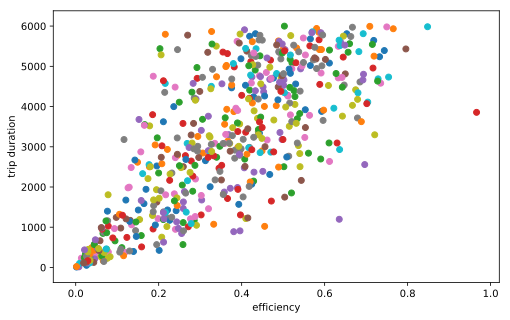

In [224]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
plt.xlabel('efficiency')
plt.ylabel('trip duration')
for i in range(res.shape[0]):
    if res['driver_info'][i] != []:
        y, x = zip(*res['driver_info'][i])
        plt.scatter(x, y)
